# Analysing Results

In [1]:
import gzip
import os

from pprint import pprint

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from deephyper.analysis import rank
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

import lcdb.json

from lcdb.analysis import read_csv_results
from lcdb.analysis import hyperparameters_from_row
from lcdb.analysis.plot import plot_learning_curves
from lcdb.analysis.plot import plot_regret_from_topk

# Pre-made queries from LCDB
from lcdb.analysis.json import JsonQuery
from lcdb.analysis.json import QueryAnchorValues
from lcdb.analysis.json import QueryMetricValuesFromAnchors
from lcdb.analysis.json import QueryAnchorKeys
from lcdb.analysis.json import QueryEpochValues
from lcdb.analysis.json import QueryMetricValuesFromEpochs
from lcdb.analysis.score import accuracy_from_confusion_matrix
from lcdb.analysis.score import balanced_accuracy_from_confusion_matrix

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [12]:
# Loads the data of constant (i.e., predicting the mode of the prior distribution P(Y))
source_constant = "../constant/output/lcdb.workflow.sklearn.ConstantWorkflow/3/0-0-0/output.json.gz"

with gzip.GzipFile(source_constant, "rb") as f:
    json_constant = lcdb.json.loads(f.read())

In [13]:
source_csv = "output/lcdb.workflow.sklearn.KNNWorkflow/3/42-42-42/results.csv.gz"

# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
with gzip.GzipFile(source_csv, "rb") as f:        
    r_df, r_df_failed = read_csv_results(f)
r_df

,p:metric,p:n_neighbors,p:pp@cat_encoder,p:pp@decomposition,p:pp@featuregen,p:pp@featureselector,p:pp@scaler,p:weights,p:p,p:pp@kernel_pca_kernel,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
6,minkowski,5,ordinal,none,none,none,none,uniform,2,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
10,cosine,11,ordinal,ka_nystroem,poly,none,minmax,distance,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
19,cosine,3,onehot,lda,none,none,minmax,uniform,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
20,nan_euclidean,1,onehot,lda,none,none,minmax,uniform,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
5,cosine,7,ordinal,agglomerator,poly,selectp,minmax,uniform,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,nan_euclidean,19,onehot,ka_nystroem,poly,selectp,none,distance,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
977,nan_euclidean,2,ordinal,fastica,poly,none,minmax,uniform,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
983,nan_euclidean,1,onehot,agglomerator,none,selectp,std,uniform,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
988,nan_euclidean,17,ordinal,none,none,selectp,none,distance,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [14]:
r_df[(r_df["p:metric"] == "minkowski") & r_df["m:traceback"].isna()]
# r_df[(r_df["p:metric"] == "minkowski")]

,p:metric,p:n_neighbors,p:pp@cat_encoder,p:pp@decomposition,p:pp@featuregen,p:pp@featureselector,p:pp@scaler,p:weights,p:p,p:pp@kernel_pca_kernel,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
6,minkowski,5,ordinal,none,none,none,none,uniform,2,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
0,minkowski,2,ordinal,lda,none,selectp,std,distance,8,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
35,minkowski,7,ordinal,none,none,none,std,distance,8,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
12,minkowski,21,onehot,ka_nystroem,none,none,minmax,uniform,2,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
2,minkowski,6,onehot,agglomerator,poly,selectp,std,distance,3,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,minkowski,2,ordinal,ka_rbf,none,selectp,none,distance,8,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
976,minkowski,2,onehot,ka_nystroem,none,none,std,distance,7,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
980,minkowski,31,ordinal,agglomerator,poly,selectp,std,uniform,2,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
949,minkowski,3,onehot,ka_rbf,poly,none,minmax,uniform,2,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,NaN,"{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [15]:
r_df_failed

,p:metric,p:n_neighbors,p:pp@cat_encoder,p:pp@decomposition,p:pp@featuregen,p:pp@featureselector,p:pp@scaler,p:weights,p:p,p:pp@kernel_pca_kernel,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:json
1,minkowski,60,ordinal,none,none,none,std,uniform,7,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
4,minkowski,24,ordinal,ka_nystroem,poly,none,std,uniform,6,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
8,minkowski,79,ordinal,agglomerator,none,none,none,uniform,1,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
13,minkowski,1,ordinal,ka_nystroem,poly,selectp,minmax,uniform,3,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
21,minkowski,16,onehot,agglomerator,poly,selectp,std,uniform,7,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,minkowski,28,onehot,none,poly,selectp,minmax,uniform,3,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
924,minkowski,56,ordinal,lda,none,none,std,uniform,7,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
944,minkowski,88,onehot,agglomerator,none,selectp,none,uniform,8,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."
952,minkowski,1,ordinal,none,poly,none,minmax,uniform,9,linear,...,3,42,lcdb.workflow.sklearn.KNNWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'tag': 'run', 'timestamp_start': 0.0, 'timest..."


In [16]:
print("Number of successful runs:", len(r_df))
print("Number of failed runs:", len(r_df_failed))

timestamp_start_experiment = min(r_df["m:timestamp_submit"].min(), r_df_failed["m:timestamp_submit"].min())
timestamp_end_experiement = min(r_df["m:timestamp_gather"].max(), r_df_failed["m:timestamp_gather"].max())
duration_experiment = timestamp_end_experiement - timestamp_start_experiment
print(f"Experiment duration: {duration_experiment} seconds")

Number of successful runs: 884
Number of failed runs: 112
Experiment duration: 798.6422045230865 seconds


In [17]:
# Display the error of a failed job
idx = 20
print(r_df_failed.iloc[idx]["m:traceback"])

"Traceback (most recent call last):
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 158, in build_curves
    self.compute_metrics_for_workflow()
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 265, in compute_metrics_for_workflow
    predictions, labels = self.get_predictions()
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/controller.py", line 283, in get_predictions
    keys[f"y_pred_{label_split}"] = self.workflow.predict(X_split)
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/workflow/_base_workflow.py", line 43, in predict
    y_pred = self._predict(*args, **kwargs)
  File "/lus/grand/projects/datascience/regele/polaris/lcdb/publications/2023-neurips/lcdb/workflow/sklearn/_knn.py", line 87, in _predict
    return self.learner.predict(X)
  File "/lus/grand/projects/data

In [18]:
x = []
for i, row in r_df_failed.iterrows():
    x.append(hyperparameters_from_row(row))
pd.DataFrame(x)

,metric,n_neighbors,pp@cat_encoder,pp@decomposition,pp@featuregen,pp@featureselector,pp@scaler,weights,p,pp@kernel_pca_kernel,pp@kernel_pca_n_components,pp@poly_degree,pp@selectp_percentile,pp@std_with_std
0,minkowski,60,ordinal,none,none,none,std,uniform,7,linear,0.25,2,25,True
1,minkowski,24,ordinal,ka_nystroem,poly,none,std,uniform,6,linear,0.25,2,25,True
2,minkowski,79,ordinal,agglomerator,none,none,none,uniform,1,linear,0.25,2,25,True
3,minkowski,1,ordinal,ka_nystroem,poly,selectp,minmax,uniform,3,linear,0.25,2,73,True
4,minkowski,16,onehot,agglomerator,poly,selectp,std,uniform,7,linear,0.25,2,26,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,minkowski,28,onehot,none,poly,selectp,minmax,uniform,3,linear,0.25,3,58,True
108,minkowski,56,ordinal,lda,none,none,std,uniform,7,linear,0.25,2,25,False
109,minkowski,88,onehot,agglomerator,none,selectp,none,uniform,8,linear,0.25,2,100,True
110,minkowski,1,ordinal,none,poly,none,minmax,uniform,9,linear,0.25,2,25,True


In [19]:
pd.DataFrame([hyperparameters_from_row(r_df.iloc[-1])]).iloc[0].to_dict()

{'metric': 'minkowski',
 'n_neighbors': 1,
 'pp@cat_encoder': 'ordinal',
 'pp@decomposition': 'lda',
 'pp@featuregen': 'poly',
 'pp@featureselector': 'none',
 'pp@scaler': 'std',
 'weights': 'uniform',
 'p': 7,
 'pp@kernel_pca_kernel': 'linear',
 'pp@kernel_pca_n_components': 0.25,
 'pp@poly_degree': 3,
 'pp@selectp_percentile': 25,
 'pp@std_with_std': True}

In [20]:
r_df.iloc[-1]

p:metric                                                                minkowski
p:n_neighbors                                                                   1
p:pp@cat_encoder                                                          ordinal
p:pp@decomposition                                                            lda
p:pp@featuregen                                                              poly
p:pp@featureselector                                                         none
p:pp@scaler                                                                   std
p:weights                                                                 uniform
p:p                                                                             7
p:pp@kernel_pca_kernel                                                     linear
p:pp@kernel_pca_n_components                                                 0.25
p:pp@poly_degree                                                                3
p:pp@selectp_per

## Validation Error Rate vs. Number of Samples

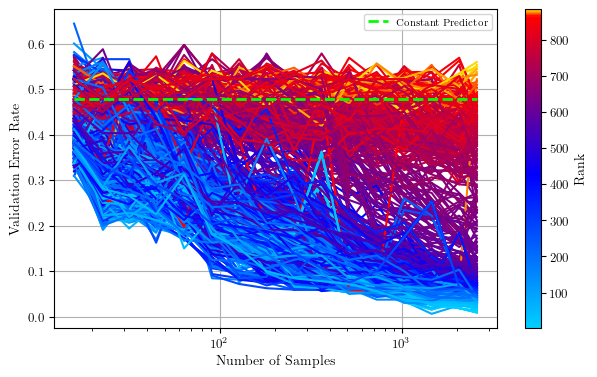

In [26]:
# Plot: Validation Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))
).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, error_rate_values)):
    anchor_values[i] = xi[: len(yi)]


anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)
error_rate_constant_predictor = list(
    map(
        lambda x: 1 - accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    anchor_values,
    error_rate_values,
    ax=ax,
    metric_value_baseline=error_rate_constant_predictor[-1],
)
ax.plot(
    anchor_values_constant_predictor,
    error_rate_constant_predictor,
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Constant Predictor",
)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Error Rate")
ax.set_xscale("log")
ax.legend()
# ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_error_rate_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

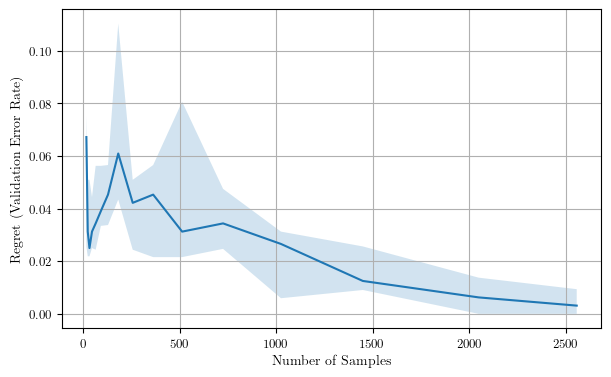

In [11]:
fig, ax = plt.subplots(figsize=figsize)
plot_regret_from_topk(anchor_values, error_rate_values, topk=10, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Regret (Validation Error Rate)")
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.savefig(os.path.join(os.path.dirname(source_csv), "val_balanced_error_rate_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

Max: 0.990625 - Min: 0.903125


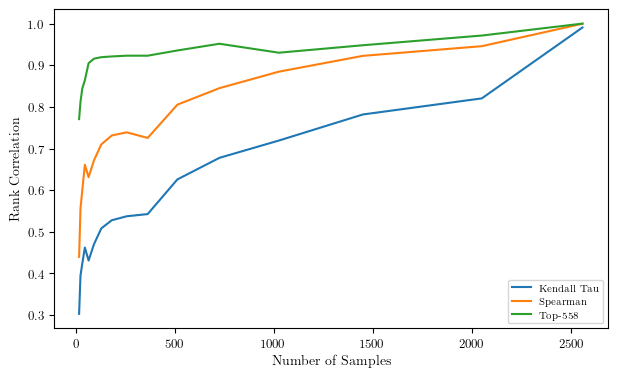

In [12]:
def pad_with_last(x, max_len):
    if len(x) < max_len:
        return x + [x[-1]] * (max_len - len(x))
    else:
        return x

max_len = max(map(len, error_rate_values))
error_rate_values = list(map(lambda x: pad_with_last(x, max_len), error_rate_values))
error_rate_values = np.array(error_rate_values)
y_star = error_rate_values[:,-1].min(axis=0)

for x in anchor_values:
    if len(x) == max_len:
        break

import scipy.stats as ss
from deephyper.analysis import rank

rank_values = rank(error_rate_values, method="ordinal", axis=0)
kendalltau_rank_correlation = lambda x: ss.kendalltau(x, rank_values[:,-1]).statistic
spearman_rank_correlation = lambda x: ss.spearmanr(x, rank_values[:,-1]).statistic
kendalltau_correlation_values = list(map(kendalltau_rank_correlation, error_rate_values.T))
spearman_correlation_values = list(map(spearman_rank_correlation, error_rate_values.T))

plt.figure(figsize=figsize)
plt.plot(x, kendalltau_correlation_values, label="Kendall Tau")
plt.plot(x, spearman_correlation_values, label="Spearman")

accepted_error = 9e-2
y_select = error_rate_values[:,-1]
y_select = y_select[np.abs(y_star - y_select) < accepted_error]
topk = len(y_select)
print(f"Max: {1-np.min(y_select)} - Min: {1-np.max(y_select)}")

idx_sorted_rank_max_fidelity = np.argsort(rank_values[:,-1])
score = lambda x: len(np.intersect1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk])) / topk
score_values = list(map(score, rank_values.T))
plt.plot(x, score_values, label=f"Top-{topk}")

plt.xlabel("Number of Samples")
plt.ylabel("Rank Correlation")
plt.legend()
plt.show()

Inferred Topk: 48
Max: 0.990625 - Min: 0.971875


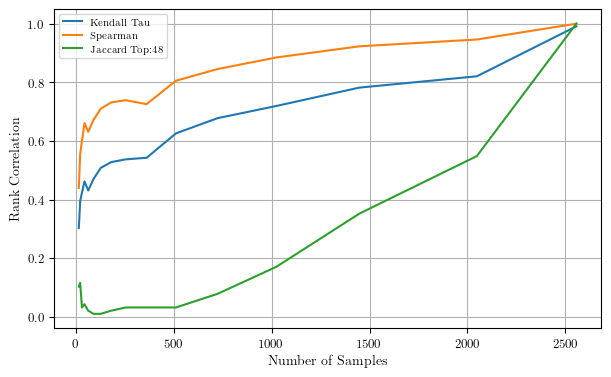

In [39]:
def pad_with_last(x, max_len):
    if len(x) < max_len:
        return x + [x[-1]] * (max_len - len(x))
    else:
        return x

max_len = max(map(len, error_rate_values))
error_rate_values = list(map(lambda x: pad_with_last(x, max_len), error_rate_values))
error_rate_values = np.array(error_rate_values)
y_star = error_rate_values[:,-1].min(axis=0)

for x in anchor_values:
    if len(x) == max_len:
        break

import scipy.stats as ss
from deephyper.analysis import rank

rank_values = rank(error_rate_values, method="ordinal", axis=0)
kendalltau_rank_correlation = lambda x: ss.kendalltau(x, rank_values[:,-1]).statistic
spearman_rank_correlation = lambda x: ss.spearmanr(x, rank_values[:,-1]).statistic
kendalltau_correlation_values = list(map(kendalltau_rank_correlation, error_rate_values.T))
spearman_correlation_values = list(map(spearman_rank_correlation, error_rate_values.T))

plt.figure(figsize=figsize)
plt.plot(x, kendalltau_correlation_values, label="Kendall Tau")
plt.plot(x, spearman_correlation_values, label="Spearman")

accepted_error = 2e-2
y_select = error_rate_values[:,-1]
y_select = y_select[np.abs(y_star - y_select) < accepted_error]
topk = len(y_select)
print(f"Inferred Topk: {topk}")
print(f"Max: {1-np.min(y_select)} - Min: {1-np.max(y_select)}")

# topk = 100
idx_sorted_rank_max_fidelity = np.argsort(rank_values[:,-1])
# score = lambda x: len(np.intersect1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk])) / topk
score = lambda x: len(np.intersect1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk])) / len(np.union1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk]))
score_values = list(map(score, rank_values.T))
plt.plot(x, score_values, label=f"Jaccard Top:{topk}")

plt.xlabel("Number of Samples")
plt.ylabel("Rank Correlation")
plt.grid()
plt.legend()
plt.show()

## Validation Error Rate vs. Time

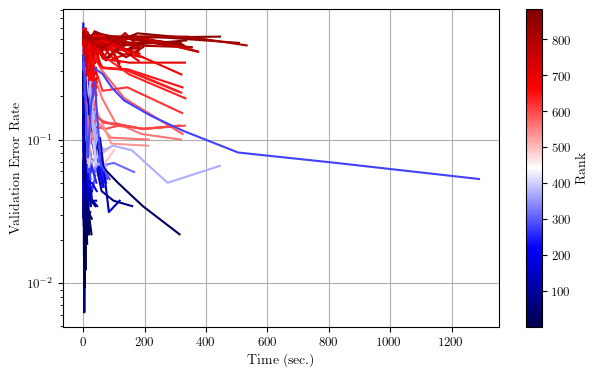

In [12]:
# Plot: Validation Error Rate vs. Time
# TODO: we may need to remove initial overheads to make all times start at 0.
source = r_df["m:json"]

query_anchor_timestamp_stop = QueryAnchorKeys("timestamp_stop")
timestamp_stop_values = source.apply(query_anchor_timestamp_stop).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors("confusion_matrix", split_name="val")
out = source.apply(query_confusion_matrix_values)
error_rate_values = out.apply(lambda x: list(map(lambda x: 1 - accuracy_from_confusion_matrix(x), x))).to_list()

for i, (xi, yi) in enumerate(zip(timestamp_stop_values, error_rate_values)):
    timestamp_stop_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(timestamp_stop_values, error_rate_values, ax=ax)
ax.set_xlabel(f"Time (sec.)")
ax.set_ylabel(f"Validation Error Rate")
# ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_error_rate_vs_time.jpg"), dpi=300, bbox_inches="tight")
plt.show()

## Validation Balanced Error Rate vs. Number of Samples

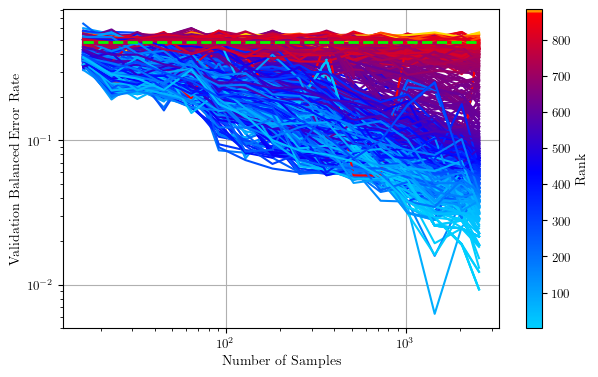

In [24]:
# Plot: Validation Balanced Error Rate vs. Number of Samples
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_confusion_matrix_values = QueryMetricValuesFromAnchors(
    "confusion_matrix", split_name="val"
)
out = source.apply(query_confusion_matrix_values)
balanced_error_rate_values = out.apply(
    lambda x: list(map(lambda x: 1 - balanced_accuracy_from_confusion_matrix(x), x))
).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, balanced_error_rate_values)):
    anchor_values[i] = xi[: len(yi)]

anchor_values_constant_predictor = query_anchor_values(
    json_constant["metadata"]["json"]
)
balanced_error_rate_constant_predictor = list(
    map(
        lambda x: 1 - balanced_accuracy_from_confusion_matrix(x),
        query_confusion_matrix_values(json_constant["metadata"]["json"]),
    )
)

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(
    anchor_values,
    balanced_error_rate_values,
    metric_value_baseline=balanced_error_rate_constant_predictor[-1],
    ax=ax,
)
ax.plot(
    anchor_values_constant_predictor,
    error_rate_constant_predictor,
    linewidth=2,
    linestyle="--",
    color="lime",
    label="Constant Predictor",
)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Balanced Error Rate")
ax.set_xscale("log")
ax.set_yscale("log")
plt.savefig(
    os.path.join(os.path.dirname(source_csv), "val_balanced_error_rate_vs_samples.jpg"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [23]:
balanced_error_rate_constant_predictor

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

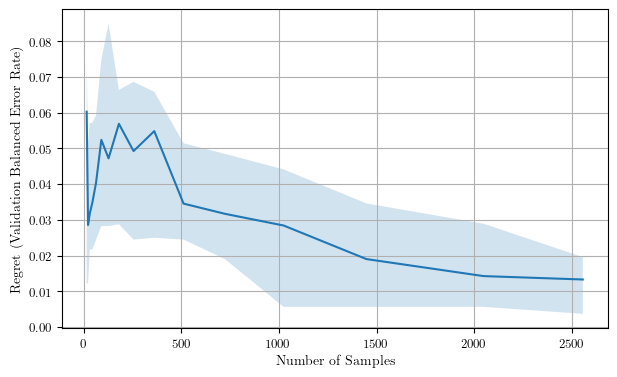

In [42]:
fig, ax = plt.subplots(figsize=figsize)
plot_regret_from_selection(anchor_values, balanced_error_rate_values, topk=50, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Regret (Validation Balanced Error Rate)")
# ax.set_xscale("log")
# ax.set_yscale("log")
# plt.savefig(os.path.join(os.path.dirname(source_csv), "val_balanced_error_rate_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [136]:
def pad_with_last(x, max_len):
    if len(x) < max_len:
        return x + [x[-1]] * (max_len - len(x))
    else:
        return x

def plot_selection_scores(x_values, y_values, y_tolerance=1e-2):
    import scipy.stats as ss
    from deephyper.analysis import rank

    max_len = max(map(len, y_values))
    y_values = list(map(lambda x: pad_with_last(x, max_len), y_values))
    y_values = np.array(y_values)

    # The best score at the maximum fidelity
    y_star = y_values[:,-1].min(axis=0)

    # The x values to plot
    for x in x_values:
        if len(x) == max_len:
            break

    # Compute the ranks
    rank_values = rank(y_values, method="ordinal", axis=0)

    # Compute the scores
    # Kendall Tau 
    kendalltau_rank_correlation = lambda x: ss.kendalltau(x, rank_values[:,-1]).statistic
    kendalltau_correlation_values = list(map(kendalltau_rank_correlation, error_rate_values.T))

    # Spearman
    spearman_rank_correlation = lambda x: ss.spearmanr(x, rank_values[:,-1]).statistic
    spearman_correlation_values = list(map(spearman_rank_correlation, error_rate_values.T))

    # Intersection Score
    y_select = y_values[:,-1]
    y_select = y_select[np.abs(y_star - y_select) < y_tolerance]
    topk = len(y_select)
    print(f"Max: {1-np.min(y_select)} - Min: {1-np.max(y_select)}")
    idx_sorted_rank_max_fidelity = np.argsort(rank_values[:,-1])
    score = lambda x: len(np.intersect1d(np.argsort(x)[:topk], idx_sorted_rank_max_fidelity[:topk])) / topk
    score_values = list(map(score, rank_values.T))

    plt.figure(figsize=figsize)
    plt.plot(x, kendalltau_correlation_values, label="Kendall Tau")
    plt.plot(x, spearman_correlation_values, label="Spearman")
    plt.plot(x, score_values, label=f"Intersection (k={topk})")
    plt.xlabel("Number of Samples")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

Max: 0.9907440021916951 - Min: 0.9809400806230676


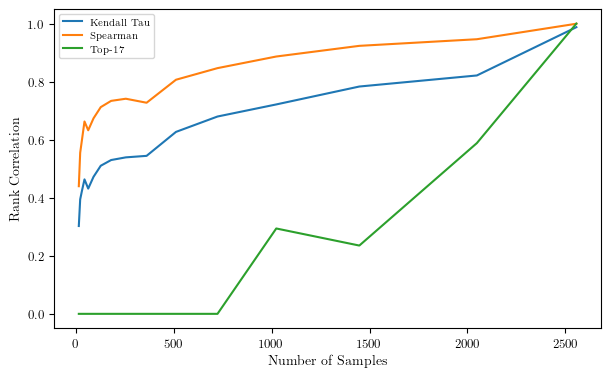

In [135]:
plot_selection_scores(anchor_values, balanced_error_rate_values)

In [144]:
def pad_with_last(x, max_len):
    if len(x) < max_len:
        return x + [x[-1]] * (max_len - len(x))
    else:
        return x

def plot_regret_from_selection(x_values, y_values):
    max_len = max(map(len, y_values))
    y_values = list(map(lambda x: pad_with_last(x, max_len), y_values))
    y_values = np.array(y_values)

    # The best score at the maximum fidelity
    y_star = y_values[:,-1].min(axis=0)

    # The x values to plot
    for x in x_values:
        if len(x) == max_len:
            break

    # Compute the regrets
    idx_selected = np.argmin(y_values, axis=0)
    regrets = list(map(lambda idx: y_values[idx, -1] - y_star, idx_selected))

    plt.figure(figsize=figsize)
    plt.plot(x, regrets)
    plt.xlabel("Number of Samples")
    plt.ylabel("Regret")
    plt.show()

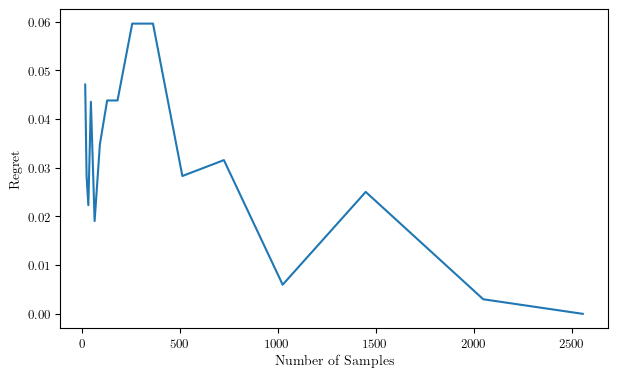

In [145]:
plot_regret_from_selection(anchor_values, balanced_error_rate_values)

## Validation LogLoss vs. Number of Samples

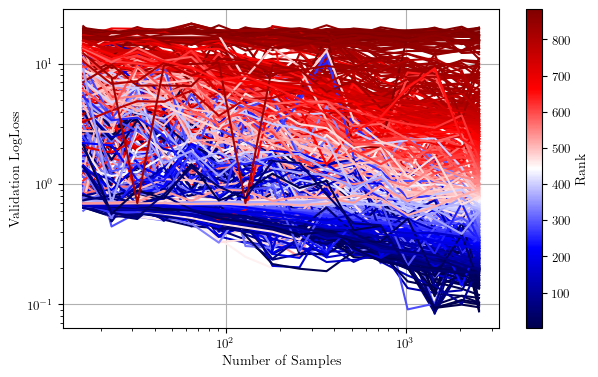

In [20]:
# Plot: Validation LogLoss vs. Time
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_log_loss_values = QueryMetricValuesFromAnchors("log_loss", split_name="val")
log_loss_values = source.apply(query_log_loss_values).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, log_loss_values)):
    anchor_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, log_loss_values, alpha=1.0, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation LogLoss")
ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_log_loss_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

## Validation Brier Score vs. Number of Samples

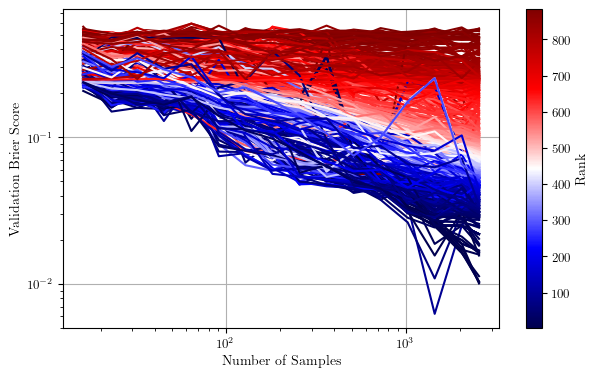

In [21]:
# Plot: Validation Brier Score vs. Time
source = r_df["m:json"]

query_anchor_values = QueryAnchorValues()
anchor_values = source.apply(query_anchor_values).to_list()

query_brier_score_values = QueryMetricValuesFromAnchors("brier_score", split_name="val")
brier_score_values = source.apply(query_brier_score_values).to_list()

for i, (xi, yi) in enumerate(zip(anchor_values, brier_score_values)):
    anchor_values[i] = xi[:len(yi)]

fig, ax = plt.subplots(figsize=figsize)
plot_learning_curves(anchor_values, brier_score_values, alpha=1.0, ax=ax)
ax.set_xlabel(f"Number of Samples")
ax.set_ylabel(f"Validation Brier Score")
ax.set_yscale("log")
ax.set_xscale("log")
plt.savefig(os.path.join(os.path.dirname(source_csv), "val_brier_score_vs_samples.jpg"), dpi=300, bbox_inches="tight")
plt.show()

In [30]:
import logging
from lcdb.cli._run import run
from deephyper.evaluator import RunningJob

logging.basicConfig(
    # filename=os.path.join(log_dir, "deephyper.log"),
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(filename)s:%(funcName)s - %(message)s",
    force=True,
)

In [32]:
config = {
    "metric": "minkowski",
    "n_neighbors": 1,
    "pp@cat_encoder": "ordinal",
    "pp@decomposition": "lda",
    "pp@featuregen": "poly",
    "pp@featureselector": "none",
    "pp@scaler": "std",
    "weights": "uniform",
    "p": 7,
    "pp@kernel_pca_kernel": "linear",
    "pp@kernel_pca_n_components": 0.25,
    "pp@poly_degree": 3,
    "pp@selectp_percentile": 25,
    "pp@std_with_std": True,
}

In [40]:
import json
config = {
    "metric": "minkowski",
    "n_neighbors": 22,
    "pp@cat_encoder": "ordinal",
    "pp@decomposition": "ka_rbf",
    "pp@featuregen": "poly",
    "pp@featureselector": "none",
    "pp@scaler": "minmax",
    "weights": "uniform",
    "p": 1,
    "pp@kernel_pca_kernel": "linear",
    "pp@kernel_pca_n_components": 0.25,
    "pp@poly_degree": 2,
    "pp@selectp_percentile": 25,
    "pp@std_with_std": True,
}
print(json.dumps(config))

{"metric": "minkowski", "n_neighbors": 22, "pp@cat_encoder": "ordinal", "pp@decomposition": "ka_rbf", "pp@featuregen": "poly", "pp@featureselector": "none", "pp@scaler": "minmax", "weights": "uniform", "p": 1, "pp@kernel_pca_kernel": "linear", "pp@kernel_pca_n_components": 0.25, "pp@poly_degree": 2, "pp@selectp_percentile": 25, "pp@std_with_std": true}


In [42]:
run(RunningJob(id=0, parameters=config), openml_id=3, monotonic=True, workflow_class="lcdb.workflow.sklearn.KNNWorkflow")

2023-12-01 16:58:36,814 - INFO - _run.py:run - Running job 0.0 with parameters: {'metric': 'minkowski', 'n_neighbors': 22, 'pp@cat_encoder': 'ordinal', 'pp@decomposition': 'ka_rbf', 'pp@featuregen': 'poly', 'pp@featureselector': 'none', 'pp@scaler': 'minmax', 'weights': 'uniform', 'p': 1, 'pp@kernel_pca_kernel': 'linear', 'pp@kernel_pca_n_components': 0.25, 'pp@poly_degree': 2, 'pp@selectp_percentile': 25, 'pp@std_with_std': True}
2023-12-01 16:58:36,816 - INFO - timer.py:start - Starting timer for 'run'
2023-12-01 16:58:36,816 - INFO - timer.py:start - Starting timer for 'load_task'
2023-12-01 16:58:36,817 - INFO - _run.py:run - Loading the dataset...
2023-12-01 16:58:36,838 - INFO - dataset.py:_cache_compressed_file_from_file - pickle write kr-vs-kp
2023-12-01 16:58:36,856 - INFO - timer.py:stop - Stopping timer for 'load_task'
2023-12-01 16:58:36,857 - INFO - _run.py:run - Importing the workflow...
2023-12-01 16:58:36,883 - INFO - timer.py:start - Starting timer for 'build_curves'
2

{'objective': 'F_value_error',
 'metadata': {'timestamp_start': 1701446316.8149068,
  'timestamp_end': 1701446316.99437,
  'memory': 2826902,
  'openmlid': 3,
  'workflow_seed': 42,
  'workflow': 'lcdb.workflow.sklearn.KNNWorkflow',
  'valid_prop': 0.1,
  'test_prop': 0.1,
  'monotonic': True,
  'valid_seed': 42,
  'test_seed': 42,
  'traceback': '"Traceback (most recent call last):\n  File "/Users/romainegele/Documents/Research/LCDB/lcdb/publications/2023-neurips/lcdb/controller.py", line 158, in build_curves\n    self.compute_metrics_for_workflow()\n  File "/Users/romainegele/Documents/Research/LCDB/lcdb/publications/2023-neurips/lcdb/controller.py", line 265, in compute_metrics_for_workflow\n    predictions, labels = self.get_predictions()\n                          ^^^^^^^^^^^^^^^^^^^^^^\n  File "/Users/romainegele/Documents/Research/LCDB/lcdb/publications/2023-neurips/lcdb/controller.py", line 283, in get_predictions\n    keys[f"y_pred_{label_split}"] = self.workflow.predict(X_spl